<h1><center><font size="25">Forecasting web traffic with machine learning and Python</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>September, 2021 (last update September, 2022)</i></center>

+ [Skforecast: time series forecasting with Python and Scikit-learn](https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)

## Introduction
<br>

A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables. This document describes how to use machine learning and statistical models in order to forecast the number of users who visit a website.
<br>

## Use case
<br>

The history of daily visits to the website [cienciadedatos.net](https://www.cienciadedatos.net) is available since 07/01/2020. The goal is to generate a forecasting model capable of predicting the web traffic during the next 7 days. The user wants to be able to run the model every Monday and obtain daily traffic predictions for the rest of the week.

To evaluate the performance of the model according to its intended use, it is advisable not to predict only the last 7 days of the time series, but to simulate the whole process. [Backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html) is a special type of cross-validation applied to the previous period(s) and can be used with different strategies:

**Backtesting with refit and increasing training size (fixed origin)**

The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.

<p align="center"><img src="./images/diagram-backtesting-refit.png" style="width: 500px;"></p>

<p align="center"><img src="./images/backtesting_refit.gif" style="width: 600px;"></p>


**Backtesting with refit and fixed training size (rolling origin)**

A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.

<p align="center"><img src="./images/diagram-backtesting-refit-fixed-train-size.png" style="width: 500px;"></p>

<p align="center"><img src="./images/backtesting_refit_fixed_train_size.gif" style="width: 600px;"></p>


**Backtesting without refit**

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest information available, so it may lose predictive capacity over time.

<p align="center"><img src="./images/diagram-backtesting-no-refit.png" style="width: 500px;"></p>

<p align="center"><img src="./images/backtesting_no_refit.gif" style="width: 600px;"></p>

<br>


The most appropriate validation method will depend on the strategy to be used in production, whether the model will be periodically retrained or not before the prediction process. Regardless of the strategy used, it is important not to include test data in the search process to avoid *overfitting* problems.

## Libreries
<br>

Libraries used in this document are:

In [54]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelling and forecasting
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error

# Warnings config
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Data
<br>

Data has been obtained from the google analytics service integrated into the website and can be downloaded [here](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/blob/master/data/visits_por_day_web_cienciadedatos.csv). The fields included are:

+ date: day/month/year

+ users: total number of users who visit the web

In [55]:
# Data downloading
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/' +
       'master/data/visitas_por_dia_web_cienciadedatos.csv')
data = pd.read_csv(url, sep=',')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    421 non-null    object
 1   users   421 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.7+ KB


Column date is stored as `object`. It is converted to `datetime` type using `pd.to_datetime ()` function. Furthermore, it is set as an index to take advantage of pandas functionalities and finally, its frequency is set to 1 day.

In [56]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%y')
data = data.set_index('date')
data = data.asfreq('1D')
data = data.sort_index()

In [57]:
# Check index is complete or there are missing values
# ==============================================================================
(data.index == pd.date_range(
                    start = data.index.min(),
                    end   = data.index.max(),
                    freq  = data.index.freq)).all()

True

In [58]:
print(f"Missing values: {data.isnull().any(axis=1).sum()}")

Missing values: 0


The data set (starts on *2020-07-01* and ends on *2021-08-22*), is divided into 3 partitions: one for training, one for validation and one for testing.

In [59]:
# Split data: train-validation-test
# ==============================================================================
end_train = '2021-03-30 23:59:00'
end_validation = '2021-06-30 23:59:00'

data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Training dates   : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Training dates   : 2020-07-01 00:00:00 --- 2021-03-30 00:00:00  (n=273)
Validation dates : 2021-03-31 00:00:00 --- 2021-06-30 00:00:00  (n=92)
Test dates       : 2021-07-01 00:00:00 --- 2021-08-25 00:00:00  (n=56)


## Graphical exploration
<br>

When working with time series, it is important to represent their values. This allows patterns such as trends and seasonality to be identified.

**Time series**

In [60]:
# Static plot
# ==============================================================================
# fig, ax = plt.subplots(figsize=(12, 4))
# data_train.users.plot(ax=ax, label='train', linewidth=1)
# data_val.users.plot(ax=ax, label='val', linewidth=1)
# data_test.users.plot(ax=ax, label='test', linewidth=1)
# ax.set_title('Daily visitors')
# ax.legend();

# Interactive plot
# ==============================================================================
plot_train = data_train.users.hvplot.line(label='train')
plot_val   = data_val.users.hvplot.line(label='val')
plot_test  = data_test.users.hvplot.line(label='test')

layout = plot_train * plot_val * plot_test
layout = layout.opts(title='Daily visitors', ylabel='users')
layout

:Overlay
   .Curve.Train :Curve   [date]   (users)
   .Curve.Val   :Curve   [date]   (users)
   .Curve.Test  :Curve   [date]   (users)

**Seasonality**

In [61]:
# Static plot
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['month'] = data.index.month
# data.boxplot(column='users', by='month', ax=ax,)
# data.groupby('month')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('users')
# ax.set_title('Monthly visitors')
# fig.suptitle('');

# Interactive plot
# ==============================================================================
data['month'] = data.index.month
boxplot  = data.sort_values('month').hvplot.box(
               y                  = 'users',
               by                 = 'month',
               legend             = False,
               box_fill_color     = None,
               outlier_fill_color = None
            )
lineplot = data.groupby('month')['users'].median().hvplot.line(legend=False)
scatterplot = data.groupby('month')['users'].median().hvplot.scatter(legend=False)
layout = boxplot * lineplot * scatterplot
layout = layout.opts(title='Monthly visitors', ylabel='users', width=600)
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [month]   (users)
   .Curve.Users   :Curve   [month]   (users)
   .Scatter.Users :Scatter   [month]   (users)

In [62]:
# Static plot
# ==============================================================================
# fig, ax = plt.subplots(figsize=(9, 3.5))
# data['month_day'] = pd.Series(data.index).dt.day.values
# data.boxplot(column='users', by='month_day', ax=ax,)
# data.groupby('month_day')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('users')
# ax.set_title('Month-day visitors')
# fig.suptitle('');

# Interactive plot
# ==============================================================================
data['month_day'] = pd.Series(data.index).dt.day.values
boxplot = data.hvplot.box(
              y                  = 'users',
              by                 = 'month_day',
              legend             = False,
              box_fill_color     = None,
              outlier_fill_color = None
          )
lineplot = data.groupby('month_day')['users'].median().hvplot.line(legend=False)
scatterplot = data.groupby('month_day')['users'].median().hvplot.scatter(legend=False)
layout = boxplot * lineplot * scatterplot
layout = layout.opts(title='Month-day visitors', ylabel='users', width=600)
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [month_day]   (users)
   .Curve.Users   :Curve   [month_day]   (users)
   .Scatter.Users :Scatter   [month_day]   (users)

In [63]:
# Static plot
# ==============================================================================
# fig, ax = plt.subplots(figsize=(7, 3.5))
# data['week_day'] = data.index.day_of_week + 1
# data.boxplot(column='users', by='week_day', ax=ax)
# data.groupby('week_day')['users'].median().plot(style='o-', linewidth=0.8, ax=ax)
# ax.set_ylabel('users')
# ax.set_title('Week-day visitors')
# fig.suptitle('');

# Interactive plot
# ==============================================================================
data['week_day'] = data.index.day_of_week + 1
boxplot = data.sort_values('week_day').hvplot.box(
              y                  = 'users',
              by                 = 'week_day',
              legend             = False,
              box_fill_color     = None,
              outlier_fill_color = None
          )
lineplot = data.groupby('week_day')['users'].median().hvplot.line(legend=False)
scatterplot = data.groupby('week_day')['users'].median().hvplot.scatter(legend=False)
layout = boxplot * lineplot * scatterplot
layout = layout.opts(
             title  = 'Week-day visitors',
             ylabel = 'users',
             width  = 600
         )
layout

:Overlay
   .BoxWhisker.I  :BoxWhisker   [week_day]   (users)
   .Curve.Users   :Curve   [week_day]   (users)
   .Scatter.Users :Scatter   [week_day]   (users)

It cannot be determined if there is an annual seasonality since the data does not span two years. However, there is a weekly seasonality, with a reduction in web traffic on weekends.

**Autocorrelation plots**

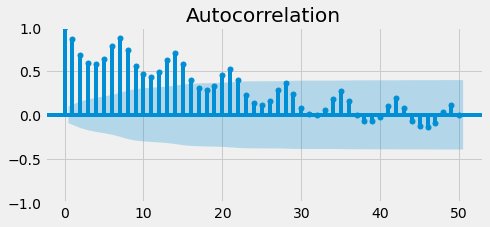

In [64]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(data.users, ax=ax, lags=50)
plt.show()

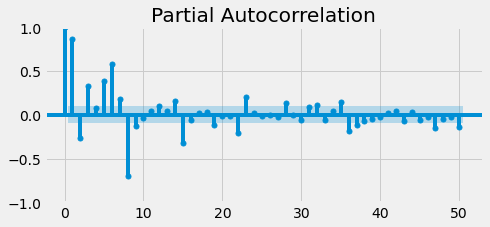

In [65]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(data.users, ax=ax, lags=50)
plt.show()

Autocorrelation and partial autocorrelation plots show a clear association between the number of users on a day and the previous days. This is an indication that autoregressive models may achive good predictions.
<br><br>

## Autoregressive model
<br>

A autoregressive model (`ForecasterAutoreg`) is trained using a linear regressor with Ridge regularization, and a time window of 2 weeks (14 lags). The latter means that, for each prediction, the traffic the website had in the previous 14 days is used as predictors. 

Ridge models require predictors to be standardized. A `StandardScaler` is added to the forecaster using the argument `transformer_y`. 

### Training Forecaster

In [66]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=data_train.users)
forecaster

ForecasterAutoreg 
Regressor: Ridge(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 14 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-07-01 00:00:00'), Timestamp('2021-03-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-10-01 12:18:49 
Last fit date: 2022-10-01 12:18:49 
Skforecast version: 0.5.0 
Python version: 3.9.13 

### Prediction (*backtest*)
<br>

In order to evaluate the model, it is trained using data from 2020-07-01 to 2021-06-30 and then, predictions are made seven days at a time, without retraining the model. This type of validation is known as *backtesting*, and can be easily applied with the function `backtesting_forecaster ()`.

In [67]:
# Backtest
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.users,
                          initial_train_size = len(data.loc[:end_validation]),
                          steps              = 7,
                          refit              = False,
                          fixed_train_size   = False,
                          metric             = 'mean_absolute_error',
                          verbose            = True
                      )

print(f'Backtest error: {metric}')
predictions.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-01 00:00:00 -- 2021-07-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-08 00:00:00 -- 2021-07-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-15 00:00:00 -- 2021-07-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-22 00:00:00 -- 2021-07-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-29 00:00:00 --

,pred
2021-07-01,3199.921107
2021-07-02,2998.675773
2021-07-03,2256.899442
2021-07-04,2038.767690
2021-07-05,2998.858487


In [68]:
# Plot
# ==============================================================================
# fig, ax = plt.subplots(figsize=(10, 3))
# data_test.loc[predictions.index, 'users'].plot(ax=ax, linewidth=2, label='test')
# predictions.plot(linewidth=2, label='prediction', ax=ax)
# ax.set_title('Predictions vs real values')
# ax.legend();

plot_test = data_test.users.hvplot.line(label='test')
plot_predict = predictions.hvplot.line(label='prediction')
layout = plot_test * plot_predict
layout = layout.opts(
             title = 'Predictions vs real values',
             ylabel = 'users',
             legend_position = 'bottom_left'
         )
layout

:Overlay
   .Curve.Test       :Curve   [date]   (users)
   .Curve.Prediction :Curve   [index]   (pred)

### Tuning the hyper-parameters
<br>

In the previous section, the first 14 lags have been used as predictors and a linear model with the  default hyperparameters as regressor. However, there is no reason why these values should be the most appropriate.

In order to identify the best combination of lags and hyperparameters, a grid search is used. This process consists of training a model with each combination of hyperparameters-lags, and evaluating its predictive capacity using backtesting. It is important to evaluate the models using only the validation data and not include the test data.

In [69]:
# Grid search of hyper-parameters
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler()
             )

# Regressor's hyper-parameters
param_grid = {'alpha': np.logspace(-3, 3, 10)}

# Lags used as predictors
lags_grid = [7, 14, 21, [7, 14, 21]]

grid_results = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = data.loc[:end_validation, 'users'],
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = 7,
                   metric             = 'mean_absolute_error',
                   refit              = False,
                   initial_train_size = len(data_train),
                   fixed_train_size   = False,
                   return_best        = True,
                   verbose            = False
               )

Number of models compared: 40.


loop lags_grid: 100%|███████████████████████████████████████| 4/4 [00:02<00:00,  1.99it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
  Parameters: {'alpha': 2.154434690031882}
  Backtesting metric: 214.79167668434636



In [70]:
# Grid search results
# ==============================================================================
grid_results

,lags,params,mean_absolute_error,alpha
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 2.154434690031882},214.791677,2.154435
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.46415888336127775},216.551409,0.464159
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.1},217.770757,0.100000
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.021544346900318832},218.127429,0.021544
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.004641588833612777},218.206475,0.004642
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 0.001},218.223609,0.001000
26,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 10.0},219.315042,10.000000
16,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]",{'alpha': 10.0},220.932702,10.000000
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 2.154434690031882},221.500069,2.154435
24,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.46415888336127775},226.720683,0.464159


The best results are obtained using lags [1 2 3 4 5 6 7 8 9 10 11 12 13 14] and a configuration of *Ridge {'alpha': 2.154}*. By indicating `return_best = True` in the `grid_search_forecaster` function, at the end of the process, the forecaster object is automatically retrained with the best configuration and the whole data set.

In [71]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=2.154434690031882, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 14 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2020-07-01 00:00:00'), Timestamp('2021-06-30 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'alpha': 2.154434690031882, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.001} 
Creation date: 2022-10-01 12:18:49 
Last fit date: 2022-10-01 12:18:52 
Skforecast version: 0.5.0 
Python version: 3.9.13 

Once the best model has been identified and trained (using both, the training and the validation set), its prediction error is calculated with the test set.

In [72]:
# Backtest final model using test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.users,
                          initial_train_size = len(data.loc[:end_validation, :]),
                          steps              = 7,
                          refit              = False,
                          fixed_train_size   = False,
                          metric             = 'mean_absolute_error',
                          verbose            = True
                      )

print(f'Backtest error using test data: {metric}')

Information of backtesting process
----------------------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-01 00:00:00 -- 2021-07-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-08 00:00:00 -- 2021-07-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-15 00:00:00 -- 2021-07-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-22 00:00:00 -- 2021-07-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-29 00:00:00 --

After optimizing lags and hyperparameters, it has been possible to reduce the prediction error.
<br><br>

## ARIMA model
<br>

To train an ARIMA model, the [SARIMAX](https://www.statsmodels.org/stable/examples/notebooks/generated/statespace_sarimax_stata.html) class from statsmodels can be used. A SARIMAX model is equivalent to an ARIMA model if the argument *seasonal_order = (0, 0, 0, 0)* and *trend = 'c'*. Using the fuction `backtesting_sarimax_statsmodels()` from the `model_selection_statsmodels` module is it very easy to evaluate how the model would have behaved.

In [73]:
# Backtest ARIMA
# ==============================================================================
metric, predictions = backtesting_sarimax(
                          y                  = data.users,
                          order              = (14, 0, 0),
                          initial_train_size = len(data.loc[:end_validation]),
                          steps              = 7,
                          metric             = 'mean_absolute_error',
                          refit              = False,
                          fixed_train_size   = False,
                          verbose            = True,
                          fit_kwargs         = {'maxiter': 500, 'disp': 0}
                      )

print(f'Backtest error: {metric}')
predictions.head(5)

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Backtest error: 212.0310574381383


,predicted_mean,lower users,upper users
2021-07-01,3167.085128,2647.153980,3687.016276
2021-07-02,2978.461443,2265.072869,3691.850016
2021-07-03,2235.021529,1442.052137,3027.990921
2021-07-04,1997.450190,1128.958272,2865.942108
2021-07-05,2974.884228,2040.209516,3909.558939


In [74]:
# fig, ax = plt.subplots(figsize=(10, 3))
# data_test.loc[predictions.index, 'users'].plot(linewidth=2, label='test', ax=ax)
# predictions.plot(linewidth=2, label='prediction', ax=ax)
# ax.set_title('Predictions (ARIMA) vs real values')
# ax.legend();

plot_test = data_test.users.hvplot.line(label='test')
plot_predict = predictions['predicted_mean'].hvplot.line(label='prediction')
layout = plot_test * plot_predict
layout = layout.opts(
             title = 'Predictions (ARIMA) vs real values',
             ylabel = 'users',
             legend_position = 'bottom_left'
         )
layout

:Overlay
   .Curve.Test       :Curve   [date]   (users)
   .Curve.Prediction :Curve   [index]   (predicted_mean)

### Tuning the hyper-parameters
<br>

As is the case of most models, ARIMA has several hyperparameters that control its behavior:

+ p: number of lags included as predictors in the autoregressive model.

+ d: number of times the data is differentiated, this is the number of times that the previous value is subtracted from each value.

+ q: window size for the moving average.

In the statsmodels implementation, these hyperparameters are indicated via the `order` argument. Two good references for more details on ARIMA models are: https://openforecast.org/adam/ARIMA.html and https://otexts.com/fpp3/arima.html.

With the `grid_search_sarimax` function, a hyperparameter search can be performed by comparing the models according to a metric obtained by backtesting.

In [75]:
# Grid search of hyper-parameters
# ==============================================================================
param_grid = {'order': [(14, 0, 0), (14, 2, 0), (14, 1, 0), (14, 1, 1),
                        (21, 0, 0), (21, 0, 0), (21, 1, 0), (21, 1, 1)]}

results = grid_search_sarimax(
              y                  = data.users,
              param_grid         = param_grid,
              initial_train_size = len(data.loc[:end_validation]),
              steps              = 7,
              metric             = 'mean_absolute_error',
              refit              = False,
              fixed_train_size   = False,
              verbose            = False,
              fit_kwargs         = {'maxiter': 200, 'disp': 0}
          )

results

root       INFO  Number of models compared: 8
100%|███████████████████████████████████████████████████████| 8/8 [01:00<00:00,  7.50s/it]


,params,metric,order,seasonal_order,trend
7,"{'order': (21, 1, 1), 'seasonal_order': (0, 0,...",181.326152,"(21, 1, 1)","(0, 0, 0, 0)",None
6,"{'order': (21, 1, 0), 'seasonal_order': (0, 0,...",182.100677,"(21, 1, 0)","(0, 0, 0, 0)",None
4,"{'order': (21, 0, 0), 'seasonal_order': (0, 0,...",185.579786,"(21, 0, 0)","(0, 0, 0, 0)",None
5,"{'order': (21, 0, 0), 'seasonal_order': (0, 0,...",185.579786,"(21, 0, 0)","(0, 0, 0, 0)",None
3,"{'order': (14, 1, 1), 'seasonal_order': (0, 0,...",193.904636,"(14, 1, 1)","(0, 0, 0, 0)",None
2,"{'order': (14, 1, 0), 'seasonal_order': (0, 0,...",194.076334,"(14, 1, 0)","(0, 0, 0, 0)",None
1,"{'order': (14, 2, 0), 'seasonal_order': (0, 0,...",201.139042,"(14, 2, 0)","(0, 0, 0, 0)",None
0,"{'order': (14, 0, 0), 'seasonal_order': (0, 0,...",212.031057,"(14, 0, 0)","(0, 0, 0, 0)",None


In [76]:
# Backtest final model using test data
# ==============================================================================
metric, predictions = backtesting_sarimax(
                          y                  = data.users,
                          order              = (21, 1, 1),
                          seasonal_order     = (0, 0, 0, 0),
                          initial_train_size = len(data.loc[:end_validation]),
                          fixed_train_size   = False,
                          steps              = 7,
                          metric             = 'mean_absolute_error',
                          refit              = False,
                          verbose            = True,
                          fit_kwargs         = {'maxiter': 250, 'disp': 0}
                      )

print(f'Backtest error: {metric}')

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Backtest error: 181.3261523871715


## Forecasting adding exogenous features
<br>

In the previous example, only lags of the target variable itself have been used as predictors. In certain scenarios, it is possible to have information on other variables, **whose future value is known**, that can serve as additional predictors in the model. Some typical examples are:

+ Holidays (local, national...)

+ Month of the year

+ Day of the week

+ Time of day

In this use case, the graphical analysis showed evidence that, on weekends, the number of visits to the website is reduced. The day of the week to which each date corresponds can be known in advance, therefore it can be used as an exogenous variable. See how it affects the models if this information is included as a predictor.

In [77]:
# Creation of new exogenous features
# ==============================================================================
data=data.drop(columns=['month', 'month_day'])
# One hot encoding of week day
data=pd.get_dummies(data, columns=['week_day'])
data.head(3)

,users,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6,week_day_7
date,,,,,,,,
2020-07-01,2324,0,0,1,0,0,0,0
2020-07-02,2201,0,0,0,1,0,0,0
2020-07-03,2146,0,0,0,0,1,0,0


In [78]:
# Split data train-val-test
# ==============================================================================
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

### ForecasterAutoreg

In [79]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(alpha=2.15, random_state=123),
                 lags          = 14,
                 transformer_y = StandardScaler()
             )

col_exog = [column for column in data.columns if column.startswith(('week'))]
forecaster.fit(y=data_train.users, exog=data_train[col_exog])

# Backtest forecaster with exogenous features
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = data.users,
                          exog               = data[col_exog],
                          initial_train_size = len(data.loc[:end_validation, :]),
                          steps              = 7,
                          metric             = 'mean_absolute_error',
                          refit              = False,
                          fixed_train_size   = False,
                          verbose            = True
                      )

print(f'Backtest error: {metric}')
predictions.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7

Data partition in fold: 0
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-01 00:00:00 -- 2021-07-07 00:00:00  (n=7)
Data partition in fold: 1
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-08 00:00:00 -- 2021-07-14 00:00:00  (n=7)
Data partition in fold: 2
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-15 00:00:00 -- 2021-07-21 00:00:00  (n=7)
Data partition in fold: 3
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-22 00:00:00 -- 2021-07-28 00:00:00  (n=7)
Data partition in fold: 4
    Training:   2020-07-01 00:00:00 -- 2021-06-30 00:00:00  (n=365)
    Validation: 2021-07-29 00:00:00 --

,pred
2021-07-01,3286.890749
2021-07-02,3021.079567
2021-07-03,2256.401254
2021-07-04,1985.650262
2021-07-05,3039.877224


### ARIMA

In [80]:
# Backtest ARIMA with exogenous features
# ==============================================================================
metric, predictions = backtesting_sarimax(
                          y                  = data.users,
                          exog               = data[col_exog],
                          order              = (21, 1, 1),
                          seasonal_order     = (0, 0, 0, 0),
                          initial_train_size = len(data.loc[:end_validation]),
                          steps              = 7,
                          metric             = 'mean_absolute_error',
                          refit              = False,
                          fixed_train_size   = False,
                          verbose            = True,
                          fit_kwargs         = {'maxiter': 250, 'disp': 0},
                      )

print(f'Backtest error: {metric}')
predictions.head(5)

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Backtest error: 181.33787764919785


,predicted_mean,lower users,upper users
2021-07-01,3190.625282,2708.197231,3673.053333
2021-07-02,2986.837645,2300.565222,3673.110069
2021-07-03,2208.817468,1427.201295,2990.433642
2021-07-04,1960.838156,1095.149075,2826.527237
2021-07-05,3021.327297,2082.260596,3960.393999


## Prediction intervals
<br>

Both functions, `backtesting_forecaster` and `backtesting_sarimax`, allow to obtain, in addition to the predictions, their intervals.

In [81]:
# Backtest with prediction intervals
# ==============================================================================
metric, predictions = backtesting_sarimax(
                          y                  = data.users,
                          exog               = data[col_exog],
                          order              = (21, 1, 1),
                          seasonal_order     = (0, 0, 0, 0),
                          initial_train_size = len(data.loc[:end_validation]),
                          steps              = 7,
                          metric             = 'mean_absolute_error',   
                          alpha              = 0.05,
                          refit              = False,
                          fixed_train_size   = False,
                          verbose            = True,
                          fit_kwargs         = {'maxiter': 250, 'disp': 0},
                      )

print(f'Backtest error: {metric}')
predictions.head(5)

Number of observations used for training: 365
Number of observations used for backtesting: 56
    Number of folds: 8
    Number of steps per fold: 7
Backtest error: 181.33787764919785


,predicted_mean,lower users,upper users
2021-07-01,3190.625282,2708.197231,3673.053333
2021-07-02,2986.837645,2300.565222,3673.110069
2021-07-03,2208.817468,1427.201295,2990.433642
2021-07-04,1960.838156,1095.149075,2826.527237
2021-07-05,3021.327297,2082.260596,3960.393999


In [82]:
# Static plot
# ==============================================================================
# fig, ax = plt.subplots(figsize=(10, 3))
# data_test.loc[predictions.index, 'users'].plot(linewidth=2, label='test', ax=ax)
# predictions.iloc[:, 0].plot(linewidth=2, label='prediction', ax=ax)
# ax.set_title('Predictions (ARIMA) vs real values')
# ax.fill_between(
#     predictions.index,
#     predictions.iloc[:, 1],
#     predictions.iloc[:, 2],
#     alpha = 0.2,
#     color = 'red',
#     label = 'prediction interval' 
# )
# ax.legend();

# Interactive plot
# ==============================================================================
plot_test = data_test.users.hvplot.line(label='test')
plot_predict = predictions['predicted_mean'].hvplot.line(label='prediction')
plot_intervalo = predictions.hvplot.area(
                     y     = 'lower users',
                     y2    = 'upper users',
                     color = 'red',
                     alpha = 0.2,
                     label = 'prediction interval'
                 )
layout = plot_intervalo * plot_test * plot_predict
layout = layout.opts(
             title = 'Predictions (ARIMA) vs real values',
             ylabel = 'users',
             legend_position = 'bottom_left'
         )
layout

:Overlay
   .Area.Prediction_interval :Area   [index]   (lower users,upper users)
   .Curve.Test               :Curve   [date]   (users)
   .Curve.Prediction         :Curve   [index]   (predicted_mean)

## Conclusion
<br>

Best results are achived using an ARIMA.


| Model | Exogenous features | MAE backtest |
|:------:|:------------------:|:------------:|
| ARIMA  | False              | 181.3     |
| ARIMA  | True               | 181.3     |
| Autoregresivo-ridge   | False             | 216.3    |
| Autoregresivo-ridge   | True              | 195.8     |

How to further improve the model:

+ Adding as exogenous feature vacation days.

+ Using non linear regressors such as random forest or gradient boosting [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html).

+ Using a [direct multi-step forecaster](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/direct-multi-step-forecasting.html).


## Session information

In [83]:
import session_info
session_info.show(html=False)

-----
holoviews           1.15.0
hvplot              0.8.1
ipykernel           5.5.6
matplotlib          3.5.0
numpy               1.23.0
pandas              1.4.0
seaborn             0.11.0
session_info        1.0.0
skforecast          0.5.0
sklearn             1.1.0
statsmodels         0.13.0
-----
IPython             8.5.0
jupyter_client      7.3.5
jupyter_core        4.11.1
notebook            6.4.12
-----
Python 3.9.13 (main, Aug 25 2022, 23:26:10) [GCC 11.2.0]
Linux-5.15.0-48-generic-x86_64-with-glibc2.31
-----
Session information updated at 2022-10-01 12:21


## References
<br>

Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [book](https://otexts.com/fpp3/)

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov [book](https://openforecast.org/adam/)

Python for Finance: Mastering Data-Driven Finance [book](https://www.amazon.es/gp/product/1492024333/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1492024333&linkId=70c3175ad015970cd1c2328b7a40a055)

**How to cite this document?**

<p style="text-align:left"><font size="3" color="#555">
Forecasting web traffic with machine learning and Python by Joaquín Amat Rodrigo and Javier Escobar Ortiz, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/py36-forecasting-visitas-web-machine-learning.html
    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by  Joaquín Amat Rodrigo and Javier Escobar Ortiz is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.